In [14]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import seaborn as sns
import warnings
from sklearn.cluster import KMeans
from kneed import KneeLocator
import collections
import auxiliary_functions
import pprint
import json

In [2]:
import inspect
inspect.getargspec(auxiliary_functions.ranking_calculation)

C:\Users\elsal\AppData\Local\Temp\ipykernel_20256\3484617465.py:2: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
  inspect.getargspec(auxiliary_functions.ranking_calculation)


ArgSpec(args=['i', 'index_top_3', 'value_top_3', 'user_queries', 'average_cluster', 'key', 'count'], varargs=None, keywords=None, defaults=None)

In [3]:
###################################################################
## Read data
###################################################################

data = pd.read_csv("./data_house/database.csv", sep = ',') 
column_names = data.columns
n = len(data.columns)
print("Dataset shape:", data.shape)

# Normalize data
data_normal = pd.DataFrame(StandardScaler().fit_transform(data), columns = column_names)

Dataset shape: (10000, 13)


In [4]:
###################################################################
## Dimensionality reduction
###################################################################

pca = PCA(n_components = 0.70)
data = pca.fit_transform(data_normal)
data = pd.DataFrame(data)
print(data.shape)

(10000, 9)


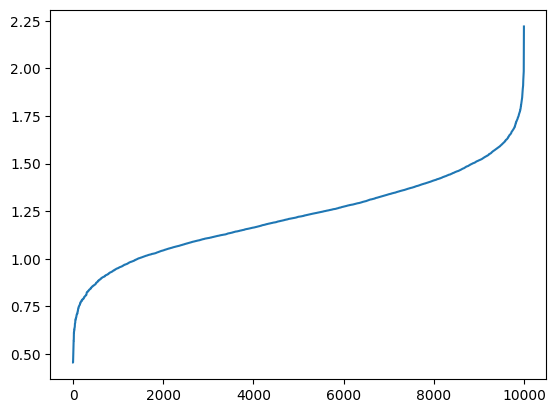

In [5]:
###################################################################
## Find parameters of DBSCAN
###################################################################

neighb = NearestNeighbors(n_neighbors=n) 
nbrs=neighb.fit(data) # fitting the data to the object
distances,indices=nbrs.kneighbors(data) # finding the nearest neighbours

# Sort and plot the distances results
plt.figure()
distances = np.sort(distances, axis = 0) # sorting the distances
distances = distances[:, 1] # taking the second column of the sorted distances
plt.rcParams['figure.figsize'] = (5,3) # setting the figure size
plt.plot(distances) # plotting the distances
plt.savefig('./data_house/figure_pre_dbsacn') # showing the plot

In [6]:
###################################################################
## DBSCAN
###################################################################
# clusters
print('\n-----------------DBSCAN--------------\n')
dbscan = DBSCAN(eps = 1.5, min_samples = 8).fit(data) 
core_samples_mask = np.zeros_like(dbscan.labels_, dtype=bool)
core_samples_mask[dbscan.core_sample_indices_] = True
labels = dbscan.labels_ # getting the labels

print("Labels for DBSCAN: ",np.unique(labels))
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
print('n_clusters for DBSCAN: ', n_clusters_)


-----------------DBSCAN--------------

Labels for DBSCAN:  [-1  0  1  2  3  4  5  6]
n_clusters for DBSCAN:  7



-----------------k-means--------------

knee elbow:  10


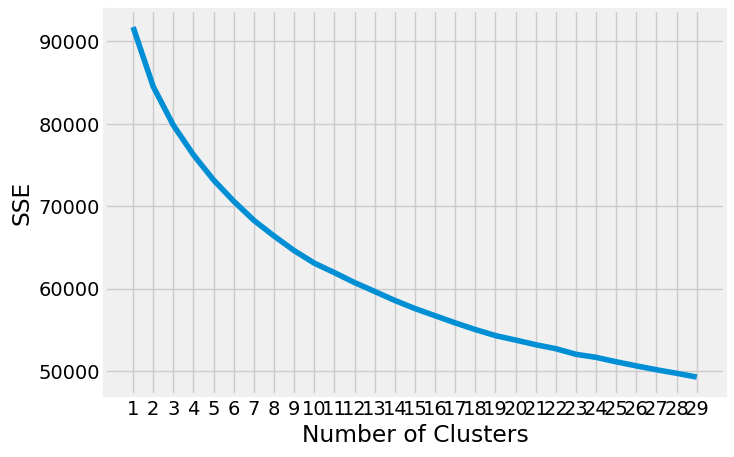

In [7]:
###################################################################
## K-MEANS
###################################################################
print('\n-----------------k-means--------------\n')
kmeans_kwargs = {"init": "random","n_init": 10,"max_iter": 300,"random_state": 42}
# A list holds the SSE values for each k
sse = []
for k in range(1, 30):
    kmeans = KMeans(n_clusters=k, **kmeans_kwargs)
    kmeans.fit(data)
    sse.append(kmeans.inertia_)

plt.figure(figsize=(8,5))
plt.style.use("fivethirtyeight")
plt.plot(range(1, 30), sse)
plt.xticks(range(1, 30))
plt.xlabel("Number of Clusters")
plt.ylabel("SSE")
plt.savefig('./data_house/kmeans.png')

kl = KneeLocator(range(1, 30), sse, curve="convex", direction="decreasing")
print('knee elbow: ',kl.elbow)

In [8]:
#kmeans = KMeans(init="random", n_clusters=kl.elbow, n_init=10, max_iter=300,random_state=42)
kmeans = KMeans(init="random", n_clusters=10, n_init=10, max_iter=300,random_state=42)
kmeans.fit(data)
print('labels k-means: ', np.unique(kmeans.labels_))
n_clusters_kmeans = len(set(kmeans.labels_)) - (1 if -1 in kmeans.labels_ else 0)
print('n_clusters for kmeans: ', n_clusters_kmeans)

labels k-means:  [0 1 2 3 4 5 6 7 8 9]
n_clusters for kmeans:  10



----------------Plot-----------------



C:\Users\elsal\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\manifold\_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
C:\Users\elsal\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\manifold\_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


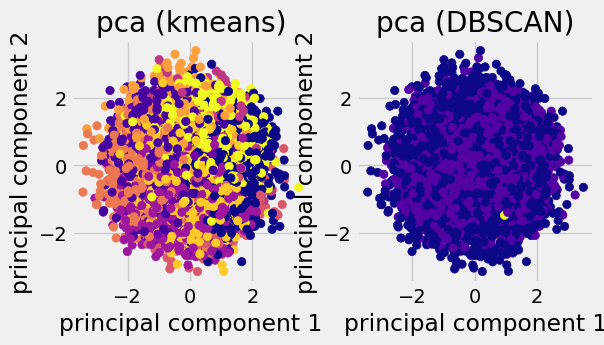

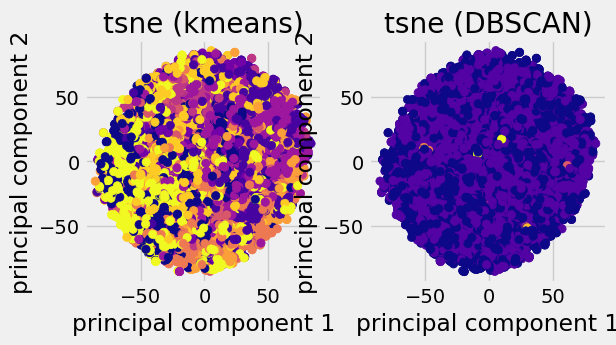

In [10]:
###################################################################
## Plot
###################################################################
print('\n----------------Plot-----------------\n')
auxiliary_functions.plot_data(data, data_normal, kmeans.labels_, labels)

In [11]:
###################################################################
## Assign queries to clusters
###################################################################
print('-------------------query assignement-------------\n')

queries =  pd.read_csv("./data_house/queries_to_use.csv", sep = ',', index_col = 0)
data = pd.read_csv("./data_house/database.csv", sep = ',') 
data['cluster_id_kmeans'] = kmeans.labels_
data['cluster_id_dbscan'] = labels
column_names_queries = queries.columns

matching_outputs = auxiliary_functions.queries_to_tuples(queries,data, kmeans.labels_, n)
matching_outputs.to_csv('data_house/matching_outputs.csv', header = False, sep = ',', index=False)
maxValueIndex = matching_outputs.idxmax(axis = 1)
queries['kmeans_label_id'] = maxValueIndex

print('-------------queries-----------\n')
print("Used clusters: ", np.unique(queries['kmeans_label_id']))
event_counts = collections.Counter(queries['kmeans_label_id'])
pprint.pprint(event_counts)

print('-------------database-----------\n')
print("Database: ", np.unique(data['cluster_id_kmeans']))
event_counts = collections.Counter(data['cluster_id_kmeans'])
pprint.pprint(event_counts)


-------------------query assignement-------------

-------------queries-----------

Used clusters:  ['1' '2' '4' '5' '6']
Counter({'5': 922, '6': 442, '1': 337, '4': 245, '2': 54})
-------------database-----------

Database:  [0 1 2 3 4 5 6 7 8 9]
Counter({5: 1089,
         0: 1062,
         2: 1009,
         1: 1002,
         6: 998,
         7: 997,
         9: 984,
         3: 965,
         4: 955,
         8: 939})


In [12]:
queries.to_csv("./data_house/queries_labels.csv", sep = ',', header = True, index = False)

In [35]:
###################################################################
## Jaccard similarity between queries
###################################################################
print('--------------jaccard similarity-----------\n')

dict_queries = auxiliary_functions.queries_as_sets(queries, './jsonfiles/query_set.json')
    
user_queries =  pd.read_csv("./data_house/user_queries.csv", sep = ',')
recomendations_index = pd.DataFrame(0, index = range(len(user_queries)), columns =['user_id','top1', 'top2', 'top3', 'top4', 'top5'])
recomendations_value = pd.DataFrame(0, index = range(len(user_queries)), columns =['user_id','top1', 'top2', 'top3', 'top4', 'top5'])
count_value = pd.DataFrame(0, index = range(len(user_queries)), columns =['user_id','case1', 'case2', 'case3', 'prop1', 'prop2', 'prop3'])

for i in range(len(user_queries)):
    gvn_jsonfile = open("./jsonfiles/query_set.json")
    json_data = json.load(gvn_jsonfile)
    
    print("---------------user {}------------\n ".format(i+1))
    dict_cluster = {}
    average_cluster = {}
    user_queries_non_nan = []
    user_queries_nan = []
    
    # We create lists containing the indexes of no ranked queries and ranked queries
    for t,j in user_queries.iloc[i][1:].items():           
      if (np.isnan(j)):
          user_queries_nan.append(t)
      else:
          user_queries_non_nan.append(t)
    n_nan_queries = len(user_queries_nan)
    count = [0,0,0]

    # Create a dictionary
    for j in range(len(np.unique(queries['kmeans_label_id']))):
        dict_cluster.update({str(np.unique(queries['kmeans_label_id'])[j]) : []})
        average_cluster.update({str(np.unique(queries['kmeans_label_id'])[j]) : []})
    
    for k in range(len(user_queries_non_nan)):
        dict_cluster[str(queries['kmeans_label_id'].iloc[k])].append(user_queries_non_nan[k])
            
    # We calculate the average ranking of ranked queries in each cluster
    for j in range(len(np.unique(queries['kmeans_label_id']))):
        key = str(np.unique(queries['kmeans_label_id'])[j])
        ranking_temp = []
        for query_id in dict_cluster[key]:
            ranking_temp.append(user_queries[str(query_id)].iloc[i])
        average_cluster[key].append(sum(ranking_temp)/len(ranking_temp))

    index_top_ranking = [0,0,0,0,0]
    value_top_ranking = [0,0,0,0,0]

    for item in user_queries_nan:
        set_query_nan = json_data[str(item)]
        
        key = str(queries['kmeans_label_id'].iloc[int(item)])
        similarity = []
        index_top_3 = [0,0,0]
        value_top_3 =[0,0,0]
                
        for query_id in dict_cluster[key]:
            set_query_non_nan = json_data[str(query_id)]
            similarity_value = auxiliary_functions.jaccard_similarity(set_query_non_nan, set_query_nan)
            # similarity.append(similarity_value)
            
            if similarity_value > min(value_top_3):
                min_index = value_top_3.index(min(value_top_3))
                index_top_3[min_index] = int(query_id)
                value_top_3[min_index] = similarity_value 
        
        # Fill the ranking of the current nan query for the current user by averaging the top 3 values
        ranking, count = auxiliary_functions.ranking_calculation(i,index_top_3, value_top_3, user_queries, average_cluster, key, count)
        user_queries.at[i, str(item)] = ranking
        
        
        min_value = min(value_top_ranking) 
        if ranking > min_value:
            min_index_ranking = value_top_ranking.index(min(value_top_ranking))
            index_top_ranking[min_index_ranking] = int(item)
            value_top_ranking[min_index_ranking] =  float(ranking) 
        
        
    # Return top k queries which were previously nan and now have a high rating
    #print('Any left nan values: ', user_queries.iloc[i].hasnans)
    #print("Reccommended queries for user {}: {} .".format(user_queries['user_id'].iloc[i], sort_by_indexes(index_top_ranking, value_top_ranking, True)))
    
    # Write in the dataframe 
    recomendations_index.iloc[i] = [user_queries['user_id'].iloc[i]] + auxiliary_functions.sort_by_indexes(index_top_ranking, value_top_ranking, True)
    value_top_ranking.sort(reverse = True)
    recomendations_value.iloc[i] = [user_queries['user_id'].iloc[i]] + value_top_ranking
    prop_count = [round(i/n_nan_queries, 2) for i in count]
    print(count, prop_count)
    count_value.iloc[i] = [user_queries['user_id'].iloc[i]] + count + prop_count
    
    # We write a data frame with the counts and the proportions
    

# We save the dataframe   
recomendations_index.to_csv("./data_house/recomendations_index.csv", sep = ',', header = True, index = False)
recomendations_value.to_csv("./data_house/recomendations_value.csv", sep = ',', header = True, index = False)

--------------jaccard similarity-----------

---------------user 1------------
 
[0, 845, 384] [0.0, 0.69, 0.31]
---------------user 2------------
 
[0, 820, 397] [0.0, 0.67, 0.33]
---------------user 3------------
 
[0, 882, 344] [0.0, 0.72, 0.28]
---------------user 4------------
 
[0, 730, 486] [0.0, 0.6, 0.4]
---------------user 5------------
 
[0, 834, 493] [0.0, 0.63, 0.37]
---------------user 6------------
 
[0, 1033, 512] [0.0, 0.67, 0.33]
---------------user 7------------
 
[0, 807, 605] [0.0, 0.57, 0.43]
---------------user 8------------
 
[0, 924, 420] [0.0, 0.69, 0.31]
---------------user 9------------
 
[16, 1035, 487] [0.01, 0.67, 0.32]
---------------user 10------------
 
[0, 749, 562] [0.0, 0.57, 0.43]
---------------user 11------------
 
[0, 825, 548] [0.0, 0.6, 0.4]
---------------user 12------------
 
[0, 718, 539] [0.0, 0.57, 0.43]
---------------user 13------------
 
[0, 960, 475] [0.0, 0.67, 0.33]
---------------user 14------------
 
[0, 1035, 516] [0.0, 0.67, 0.3

In [36]:
###################################################################
## Fill out utility matrix
###################################################################
user_queries.to_csv('./data_house/user_queries_fill.csv', header = True, sep = ',')
user_queries =  pd.read_csv("./data_house/user_queries_fill.csv", sep = ',')


In [38]:
###################################################################
## We save the dict_cluster in a json file
###################################################################
with open('./jsonfiles/dict_cluster.json', "w") as outfile:
    json.dump(dict_cluster, outfile)

In [39]:
print(user_queries.iloc[:5, 1:11])

       user_id      0      1      2      3      4      5      6     7      8
0  158-86-3113  41.24  31.63  64.59  50.41  57.33  62.67  40.00  53.0  64.22
1  241-10-5564  43.90  48.63  29.86  56.00  29.64  26.00  47.47  44.0  56.00
2  338-27-8772  36.74  35.21  53.00  27.44  24.18  21.00  41.31  28.0  34.00
3  495-50-0640  78.00  72.00  92.57  98.00  96.00  92.92  66.00  96.0  65.62
4  710-35-1509  65.00  65.31  46.00  55.43  71.17  57.00  57.00  74.0  71.51


In [40]:
print(recomendations_index[:5])

       user_id  top1  top2  top3  top4  top5
0  158-86-3113   808   393    40   633   426
1  241-10-5564   117    56   130    75   153
2  338-27-8772   854  1786  1283  1646  1610
3  495-50-0640    45   593   717   919   508
4  710-35-1509   367   313   306  1999  1728


In [41]:
print(recomendations_value[:5])

       user_id   top1   top2   top3   top4   top5
0  158-86-3113  89.00  89.00  89.00  89.00  89.00
1  241-10-5564  56.00  56.00  56.00  56.00  56.00
2  338-27-8772  56.83  56.39  56.37  56.07  56.06
3  495-50-0640  98.00  98.00  98.00  98.00  98.00
4  710-35-1509  77.00  77.00  77.00  77.00  77.00


In [42]:
print(count_value[:10])

       user_id  case1  case2  case3  prop1  prop2  prop3
0  158-86-3113      0    845    384   0.00   0.69   0.31
1  241-10-5564      0    820    397   0.00   0.67   0.33
2  338-27-8772      0    882    344   0.00   0.72   0.28
3  495-50-0640      0    730    486   0.00   0.60   0.40
4  710-35-1509      0    834    493   0.00   0.63   0.37
5  491-06-8879      0   1033    512   0.00   0.67   0.33
6  309-45-7913      0    807    605   0.00   0.57   0.43
7  429-46-1809      0    924    420   0.00   0.69   0.31
8  076-95-1602     16   1035    487   0.01   0.67   0.32
9  731-61-3487      0    749    562   0.00   0.57   0.43


In [43]:
count_value.mean(axis = 0)

C:\Users\elsal\AppData\Local\Temp\ipykernel_20256\2205735361.py:1: FutureWarning: The default value of numeric_only in DataFrame.mean is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  count_value.mean(axis = 0)


case1      1.4100
case2    878.4900
case3    501.3400
prop1      0.0012
prop2      0.6354
prop3      0.3636
dtype: float64

## Experiment 1

Experiments for accuracy and error. We are going to randomly select indexes of the utility matrix that are not null. We set the values to Nan and we save the indeces so that we can later compare the origial values to the ones given by the model.

In [50]:
def utility_matrix_rec(path_user_queries_test, labels, n, kmeans_labels, matching_outputs_name, user_queries_fill_name ):
    #print('-------------------query assignement-------------\n')
    queries =  pd.read_csv("./data_house/queries_to_use.csv", sep = ',', index_col = 0)
    data = pd.read_csv("./data_house/database.csv", sep = ',') 
    data['cluster_id_kmeans'] = kmeans_labels
    data['cluster_id_dbscan'] = labels
    column_names_queries = queries.columns

    matching_outputs = auxiliary_functions.queries_to_tuples(queries,data, kmeans_labels, n)
    matching_outputs.to_csv(matching_outputs_name, header = False, sep = ',', index=False)
    maxValueIndex = matching_outputs.idxmax(axis = 1)
    queries['kmeans_label_id'] = maxValueIndex

    #print('-------------queries-----------\n')
    event_counts = collections.Counter(queries['kmeans_label_id'])

    #print('-------------database-----------\n')
    event_counts = collections.Counter(data['cluster_id_kmeans'])
    
    #print('--------------jaccard similarity-----------\n')
        
    user_queries =  pd.read_csv(path_user_queries_test, sep = ',', index_col = 0)
    recomendations_index = pd.DataFrame(0, index = range(len(user_queries)), columns =['user_id','top1', 'top2', 'top3', 'top4', 'top5'])
    recomendations_value = pd.DataFrame(0, index = range(len(user_queries)), columns =['user_id','top1', 'top2', 'top3', 'top4', 'top5'])

    for i in range(len(user_queries)):
        gvn_jsonfile = open("./jsonfiles/query_set.json")
        json_data = json.load(gvn_jsonfile)
        
        #print("---------------user {}------------\n ".format(i+1))
        dict_cluster = {}
        average_cluster = {}
        user_queries_non_nan = []
        user_queries_nan = []
        
        # We create lists containing the indexes of no ranked queries and ranked queries
        for t,j in user_queries.iloc[i][1:].items():           
            if (np.isnan(j)):
                user_queries_nan.append(t)
            else:
                user_queries_non_nan.append(t)
            n_nan_queries = len(user_queries_nan)
            count = [0,0,0]

        # Create a dictionary
        for j in range(len(np.unique(queries['kmeans_label_id']))):
            dict_cluster.update({str(np.unique(queries['kmeans_label_id'])[j]) : []})
            average_cluster.update({str(np.unique(queries['kmeans_label_id'])[j]) : []})
        
        for k in range(len(user_queries_non_nan)):
            dict_cluster[str(queries['kmeans_label_id'].iloc[k])].append(user_queries_non_nan[k])
                
        # We calculate the average ranking of ranked queries in each cluster
        for j in range(len(np.unique(queries['kmeans_label_id']))):
            key = str(np.unique(queries['kmeans_label_id'])[j])
            ranking_temp = []
            for query_id in dict_cluster[key]:
                ranking_temp.append(user_queries[str(query_id)].iloc[i])
            average_cluster[key].append(sum(ranking_temp)/len(ranking_temp))

        index_top_ranking = [0,0,0,0,0]
        value_top_ranking = [0,0,0,0,0]

        for item in user_queries_nan:
            set_query_nan = json_data[str(item)]
            
            key = str(queries['kmeans_label_id'].iloc[int(item)])
            similarity = []
            index_top_3 = [0,0,0]
            value_top_3 =[0,0,0]
                    
            for query_id in dict_cluster[key]:
                set_query_non_nan = json_data[str(query_id)]
                similarity_value = auxiliary_functions.jaccard_similarity(set_query_non_nan, set_query_nan)
                # similarity.append(similarity_value)
                
                if similarity_value > min(value_top_3):
                    min_index = value_top_3.index(min(value_top_3))
                    index_top_3[min_index] = int(query_id)
                    value_top_3[min_index] = similarity_value 
            
            # Fill the ranking of the current nan query for the current user by averaging the top 3 values
            ranking, count = auxiliary_functions.ranking_calculation(i,index_top_3, value_top_3, user_queries, average_cluster, key, count)
            user_queries.at[i, str(item)] = ranking
            
            
            min_value = min(value_top_ranking) 
            if ranking > min_value:
                min_index_ranking = value_top_ranking.index(min(value_top_ranking))
                index_top_ranking[min_index_ranking] = int(item)
                value_top_ranking[min_index_ranking] =  float(ranking) 
        
        user_queries.to_csv(user_queries_fill_name, header = True, sep = ',')

In [52]:
user_queries =  pd.read_csv("./data_house/user_queries.csv", sep = ',')
user_queries.notnull()
row, columns = user_queries.shape
length = row * (columns-1)

In [63]:
# We define a percentage -> 30%
import random
random.seed(10)

list_remove = []
len_list = len(list_remove)
user_queries_test1 = user_queries.copy()
list_remove, user_queries_test1 = auxiliary_functions.remove_numbers(user_queries, len_list, row, columns, list_remove, user_queries_test1)

print(list_remove[:5])
user_queries_test1.to_csv('./data_house/user_queries_test1.csv', header = True, sep = ',')

[[54, 988], [20, 70], [41, 155], [95, 739], [17, 1235]]


In [46]:
for item in list_remove[:5]:
    print(item, user_queries.iloc[item[0],item[1]], user_queries_test1.iloc[item[0],item[1]])

[54, 988] 29.0 nan
[20, 70] 13.0 nan
[41, 155] 16.0 nan
[95, 739] 70.0 nan
[17, 1235] 47.0 nan


In [55]:
utility_matrix_rec("data_house/user_queries_test1.csv",labels, n, kmeans.labels_, 'data_house/matching_outputs_test.csv1','data_house/user_queries_fill_test1.csv')
#auxiliary_functions.utility_matrix_rec("data_house/user_queries_test1.csv",labels, n, kmeans.labels_, 'data_house/matching_outputs_test.csv1','data_house/user_queries_fill_test1.csv')

-------------------query assignement-------------

-------------queries-----------

-------------database-----------

--------------jaccard similarity-----------

---------------user 1------------
 
---------------user 2------------
 
---------------user 3------------
 
---------------user 4------------
 
---------------user 5------------
 
---------------user 6------------
 
---------------user 7------------
 
---------------user 8------------
 
---------------user 9------------
 
---------------user 10------------
 
---------------user 11------------
 
---------------user 12------------
 
---------------user 13------------
 
---------------user 14------------
 
---------------user 15------------
 
---------------user 16------------
 
---------------user 17------------
 
---------------user 18------------
 
---------------user 19------------
 
---------------user 20------------
 
---------------user 21------------
 
---------------user 22------------
 
---------------user 23----------

In [56]:
error = []
user_queries_fill =  pd.read_csv("./data_house/user_queries_fill.csv", sep = ',')
user_queries_fill_test1 = pd.read_csv("./data_house/user_queries_fill_test1.csv", sep = ',')

user_queries_minmax = auxiliary_functions.scaler_utility_matrix(user_queries_fill)
user_queries_test1_minmax = auxiliary_functions.scaler_utility_matrix(user_queries_fill_test1)

for item in list_remove:
    error.append(abs(user_queries_minmax.iloc[item[0],item[1]] - user_queries_test1_minmax.iloc[item[0],item[1]]))
print('The averge error for the first experiment is: ', np.mean(error))

The averge error for the first experiment is:  30.73369540569851


## Experiment 2
In this case, we are going to remove a lot of rankings for a given user, and see whether the algorithm performs well even when having a large amount of missing values for a given user.

In [75]:
random.seed(10)
list_remove2 = []
len_list2 = len(list_remove)
user_queries_test2 = user_queries.copy()

In [113]:
def remove_numbers2(user_queries, len_list, row, columns, list_remove, user_queries_test):
    #We select a random user
    user = random.randint(1,len(user_queries))
    li = list(user_queries.iloc[user,1:])
    li_not_nan = [i for i, element in enumerate(li) if np.isnan(element)]
    li_nan = [i for i in range(len(li)) if i not in li_not_nan]
        
    len_list = len(li_nan)
    
    while len_list < 1400:
        j = random.randint(0,len(li_not_nan))
        
        if [user,li_not_nan[j]] in list_remove:
            continue
        else:
            list_remove.append([user,li_not_nan[j]])
            user_queries_test.iloc[user,li_not_nan[j]] = np.nan
        
        len_list = len(list_remove)
    return user,list_remove, user_queries_test

In [114]:
#user,list_remove2, user_queries_test2 = auxiliary_functions.remove_numbers2(user_queries, len_list2, row, columns, list_remove2, user_queries_test2)
user,list_remove2, user_queries_test2 = remove_numbers2(user_queries, len_list2, row, columns, list_remove2, user_queries_test2)

In [129]:
data = user_queries_test2.iloc[user]
print('Percentage of null values for the user {} is: {}'.format(user, round(data.isnull().sum()/len(data),2)*100))

Percentage of null values for the user 51 is: 72.0


In [130]:
print(list_remove2[:5])
user_queries_test2.to_csv('./data_house/user_queries_test2.csv', header = True, sep = ',')

[[73, 878], [73, 1686], [73, 1338], [73, 1660], [73, 1951]]


In [131]:
utility_matrix_rec("data_house/user_queries_test2.csv",labels, n, kmeans.labels_, 'data_house/matching_outputs_test.csv2','data_house/user_queries_fill_test2.csv')
#auxiliary_functions.utility_matrix_rec("data_house/user_queries_test2.csv",labels, n, kmeans.labels_, 'data_house/matching_outputs_test2.csv','data_house/user_queries_fill_test2.csv')

-------------------query assignement-------------



In [ ]:
error2 = []
user_queries_fill =  pd.read_csv("./data_house/user_queries_fill.csv", sep = ',')
user_queries_fill_test2 = pd.read_csv("./data_house/user_queries_fill_test2.csv", sep = ',')

user_queries_minmax = auxiliary_functions.scaler_utility_matrix(user_queries_fill)
user_queries_test2_minmax = auxiliary_functions.scaler_utility_matrix(user_queries_fill_test2)

for item in list_remove:
    error2.append(abs(user_queries_minmax.iloc[item[0],item[1]] - user_queries_test2_minmax.iloc[item[0],item[1]]))
print('The averge error for the first experiment is: ', np.mean(error2))